# 02 - Data from the Web

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
    - Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
    - Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.


TODO: 
* Comment the functions defined at the beginning
* Manually add the missing values by looking at the websites of the universities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import pickle

from tqdm import tqdm_notebook

# Tools for scraping

* `load_data` is a function that gets the json file from the main page containing the ranking at returns the extracted pandas DataFrame

* `plot_histogram` is a utility function to plot histograms.

In [2]:
def load_data(URL):
    # make a request
    r = requests.get(URL)
    r = r.json()
    # convert the data to pandas DataFrame
    df = pd.DataFrame(r['data'])
    return df

# Part 1 : Scraping www.topuniversities.com

This website is build in a specific way. We cannot have access to what we call details (faculty members (total and international) and students (total and international)) directly on the ranking page. 

To get those details we have to scrap directly the page of the site corresponding to the university. To do so we will use the function `scrape_details`. It parses a HTML file using Beautiful Soup and then extracts the required data.

All soup commands are executed between try/except in order to be able to trace the missing data. If there is a missing data, then `AttributeError` is raised and we can print a message.

In [3]:
def scrape_details(raw_file, i, df) :
    """
    Arguments:  - raw html file returned by a GET call
                - i and df are there to be able to print a useful message about the missing data 
                (i is the index in df of the current university)
    Return: detail values in the form of a dictionnary
    """
    soup = BeautifulSoup(raw_file.text,"html.parser")
    
    try:
        # getting the data on the site using Beautiful Soup
        total_faculty = soup.find('div',class_='total faculty').find('div',class_='number').text
        # extracting the values and casting them to integers
        tot_fac = int(total_faculty[1:-1].replace(',',''))
    except AttributeError:
        print('Total faculty members unavailable for ' + df.loc[i, 'name'])
        tot_fac = 0
        
    try:
        # getting the data on the site using Beautiful Soup
        total_student = soup.find('div',class_='total student').find('div',class_='number').text
        # extracting the values and casting them to integers
        tot_stu = int(total_student[1:-1].replace(',',''))
    except AttributeError:
        print('Total students unavailable for ' + df.loc[i, 'name'])
        tot_stu = 0

    try:
        # getting the data on the site using Beautiful Soup
        inter_faculty = soup.find('div',class_='inter faculty').find('div',class_='number').text
        # extracting the values and casting them to integers
        int_fac = int(inter_faculty[1:-1].replace(',',''))
    except AttributeError:
        print('International faculty members unavailable for ' + df.loc[i, 'name'])
        int_fac = 0

    try:
        # getting the data on the site using Beautiful Soup
        inter_student = soup.find('div',class_='total inter').find('div',class_='number').text
        # extracting the values and casting them to integers
        int_stu = int(inter_student[1:-1].replace(',',''))
    except AttributeError:
        print('International students unavailable for ' + df.loc[i, 'name'])
        int_stu = 0
    
        
    return {'total_faculty_members' : tot_fac, 'total_students' : tot_stu, 
            'international_faculty_members' : int_fac, 'international_students' : int_stu}

#### Getting ranking on main page

In [4]:
url_topuni = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508105606999'

# load the ranking
df_topuni = load_data(url_topuni)

# Select the interresting columns
df_topuni = df_topuni[['title','rank_display','region','country','url']]

# Rename the columns
df_topuni.columns = ['name','rank', 'region','country','url']

# Cleaning the rank attribute
df_topuni['rank'] = df_topuni['rank'].str.replace('=', '')

# keeping only the first 200 universities of the ranking
df_topuni = df_topuni.loc[:199]

# converting rank type to integer
df_topuni['rank'] = df_topuni['rank'].astype(int)

df_topuni.head()

,name,rank,region,country,url
0,Massachusetts Institute of Technology (MIT),1,North America,United States,/universities/massachusetts-institute-technolo...
1,Stanford University,2,North America,United States,/universities/stanford-university
2,Harvard University,3,North America,United States,/universities/harvard-university
3,California Institute of Technology (Caltech),4,North America,United States,/universities/california-institute-technology-...
4,University of Cambridge,5,Europe,United Kingdom,/universities/university-cambridge


#### Getting details for each university

To get details (faculty members (total and international), students (total and international)) we have to make a `GET` request on the page of each faculty (following the url collected if the dataframe). There we use the function scrape details that parses the HTML result of the `GET` request and extracts the appropriate fields.

The results for each university are stored in a dictionnary and `details` is a list of those dictionnaries.

If the required data is not available on the page, a message is printed and values are set to 0.

In [5]:
url = "https://www.topuniversities.com"
details = [] # this is a list of dictionnaries containing the details

for i in tqdm_notebook(range(200)):
    # for each university we scrap the university page
    details.append(scrape_details(requests.get(url+df_topuni.url[i]), i, df_topuni))

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

Total faculty members unavailable for New York University (NYU)
Total students unavailable for New York University (NYU)
International faculty members unavailable for New York University (NYU)
International students unavailable for New York University (NYU)
International faculty members unavailable for Indian Institute of Science (IISc) Bangalore



#### NB
The result of the previous cell is not displayed properly on Github as it required the execution of the JavaScript widget. The function `tqdm_notebook` is used to show a progress bar of the scrapping of details. The file imgs/1.png is a screenshot of what it looks like in Chrome.

<img src="imgs/1.png", width='600'>

#### Merging all the data

In [6]:
# converting details to a pandas DataFrame
details = pd.DataFrame(details)

# we no longer need the url field because we scrapped the details
df_topuni = df_topuni.drop('url', axis = 1)

# concatenating details to core data
df_topuni = pd.concat([df_topuni,details],axis=1)

#### Sanity check for unique index

In [7]:
df_topuni.index.is_unique

True

#### Adding derived columns (ratio students per faculty member and ratio of international students)

In [8]:
df_topuni['ratio_students_per_faculty_member'] = df_topuni['total_students']/df_topuni['total_faculty_members']
df_topuni['ratio_international_students'] = df_topuni['international_students']/df_topuni['total_students']

In [9]:
df_topuni.head()

,name,rank,region,country,international_faculty_members,international_students,total_faculty_members,total_students,ratio_students_per_faculty_member,ratio_international_students
0,Massachusetts Institute of Technology (MIT),1,North America,United States,1679,3717,2982,11067,3.711268,0.335863
1,Stanford University,2,North America,United States,2042,3611,4285,15878,3.705484,0.227422
2,Harvard University,3,North America,United States,1311,5266,4350,22429,5.156092,0.234785
3,California Institute of Technology (Caltech),4,North America,United States,350,647,953,2255,2.366212,0.286918
4,University of Cambridge,5,Europe,United Kingdom,2278,6699,5490,18770,3.418944,0.356899


#### Getting the matching between countries and regions (necessary for next scraping)

In [10]:
regions = {}
for i in range(len(df_topuni)):
    c = df_topuni.loc[i, 'country']
    if c not in regions.keys():
        regions[c] = df_topuni.loc[i, 'region']

# Part 2 : Scraping www.timeshighereducation.com
Assumptions
- We are using [this site](https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/-1/sort_by/rank/sort_order/asc/cols/stats) which contains the rankings of 2018.
- Rank saved within `<td class="rank ..."><td>` element
- University saved within `<a href="..." class="ranking-institution-title ..."></a>` element
- Country saved within `<div class="location"></div>` element

First, the data returned in the json file returned in the `GET` request are imported.

In [11]:
url_times = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

# load the ranking
df_times = load_data(url_times)

In [12]:
df_times.columns

Index(['aliases', 'location', 'member_level', 'name', 'nid', 'rank',
       'rank_order', 'record_type', 'scores_citations',
       'scores_citations_rank', 'scores_industry_income',
       'scores_industry_income_rank', 'scores_international_outlook',
       'scores_international_outlook_rank', 'scores_overall',
       'scores_overall_rank', 'scores_research', 'scores_research_rank',
       'scores_teaching', 'scores_teaching_rank', 'stats_female_male_ratio',
       'stats_number_students', 'stats_pc_intl_students',
       'stats_student_staff_ratio', 'subjects_offered', 'url'],
      dtype='object')

We do not need all columns, thus we extract only the ones relevant to the data we are looking for: _name, rank, country and region, number of faculty members (international and total) and number of students (international and total)._

These columns are derived as follows:
- `name`: column `name`
- `country`: `location`
- `region`: in detail URL?
- `number of faculty members (international)`: ?
- `number of faculty members (total)`: `stats_number_students` times `stats_student_staff_ratio`
- `number of students (international)`: `stats_number_students` times `stats_pc_intl_students`
- `number of students (total)`: `stats_number_students`

In [13]:
# select the interesting columns
df_times = df_times[['name', 'rank', 'location', 'stats_number_students', 'stats_student_staff_ratio',
                     'stats_pc_intl_students']]

# rename the columns
df_times.columns = ['name', 'rank', 'country', 'total_students', 'ratio_students_per_faculty_member', 
                    'ratio_international_students']

We first have to do some data cleanup:
- remove equal sign (`=`) in field `rank` (Universities having the same rank) and removing universities having a rank above 200
-  convert percentage of students in field `stats_pc_intl_students` (e.g. 83%) to float (e.g., 0.83) for multiplication
- Remove commas and cast to  type `int` for column `stats_number_students` ("number of students")

In [14]:
# Cleaning the rank attribute
df_times['rank'] = df_times['rank'].str.replace('=', '')
df_times = df_times[np.isin(df_times['rank'], ['1001+', '201–250', '251–300', '301–350', '351–400', '401–500', '501–600', '601–800', '801–1000'],
                invert=True)]
df_times['rank'] = df_times['rank'].astype(int)

# Convert percentage (e.g. 83%) to float (e.g., 0.83) for multiplication
def divide(x, n = 100):
    return float(x)/n

df_times['ratio_international_students'] = df_times['ratio_international_students'].str.replace('%', '').apply(divide, n=100)

df_times['ratio_students_per_faculty_member'] = df_times['ratio_students_per_faculty_member'].str.replace(',', '').astype(float)

# Cleaning the number of students attribute
df_times['total_students'] = df_times['total_students'].str.replace(',', '').astype(int)
df_times.head()

,name,rank,country,total_students,ratio_students_per_faculty_member,ratio_international_students
0,University of Oxford,1,United Kingdom,20409,11.2,0.38
1,University of Cambridge,2,United Kingdom,18389,10.9,0.35
2,California Institute of Technology,3,United States,2209,6.5,0.27
3,Stanford University,3,United States,15845,7.5,0.22
4,Massachusetts Institute of Technology,5,United States,11177,8.7,0.34


We can now derive new columns for the missing data fields based on the existing columns.

In [15]:
# derived columns
df_times['total_faculty_members'] = np.round(df_times['total_students'] / (df_times['ratio_students_per_faculty_member'])).astype(int)
df_times['international_students'] = np.round(df_times['total_students'] * df_times['ratio_international_students']).astype(int)
display(df_times.head())

,name,rank,country,total_students,ratio_students_per_faculty_member,ratio_international_students,total_faculty_members,international_students
0,University of Oxford,1,United Kingdom,20409,11.2,0.38,1822,7755
1,University of Cambridge,2,United Kingdom,18389,10.9,0.35,1687,6436
2,California Institute of Technology,3,United States,2209,6.5,0.27,340,596
3,Stanford University,3,United States,15845,7.5,0.22,2113,3486
4,Massachusetts Institute of Technology,5,United States,11177,8.7,0.34,1285,3800


#### Adding the attribute region based on the data we got from scraping 1

In [16]:
for i in range(len(df_times)):
    try:
        df_times.loc[i, 'region'] = regions[df_times.loc[i, 'country']]
    except KeyError:
        print('Do not know the region for ' + df_times.loc[i, 'country'] + ' ' + str(i)) 

Do not know the region for Luxembourg 178
Do not know the region for Russian Federation 193


We can add the missing entries by hand.
Topuniversities has no university from Luxembourg in top 200 and uses Russia instead of Russian Federation.

In [17]:
df_times.loc[178, 'region'] = 'Europe'
df_times.loc[193, 'region'] = 'Europe'

## Visualization
We can now answer the following questions:
- Which are the best universities in term of: 
    * (a) ratio between faculty members and students
    * (b) ratio of international students
- Answer the previous question aggregating the data by 
    * (c) country
    * (d) region
    
We answer these following questions by ploting the computed rankings. We plot the results for Times and Topuniversities next to each other to make it easier to compare the two.

In [18]:
def plot_histogram(df1, df2, x, y, title, xlab, figsize=(20,10)):
    """
    This functions plots two histograms next to each other (df1 and df2)
    adding the values on top of the bins.
    
    df1: dataframe 1
    df2: dataframe 2
    x: column name for x axis
    y: column name for y axis
    title: title to give to the histogram
    xlab: xlabel
    """
    lx = []
    lx.append(df1[x].values)
    lx.append(df2[x].values)
    ly = []
    ly.append(np.round(df1[y],2))
    ly.append(np.round(df2[y],2))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    width = 0.5 # the width of the bars
    ind = []
    ind.append(np.arange(len(ly[0])))  # the x locations for the groups
    ind.append(np.arange(len(ly[1])))
    
    for k in range(2):
        ax[k].bar(ind[k], ly[k], width, color="red")
        ax[k].set_xticks(ind[k])
        ax[k].set_xticklabels(lx[k], rotation=90, fontsize=13)
        for i, v in enumerate(ly[k]):

            ax[k].text(i-width/2, v*1.02, str(v), color='red', fontsize = 15)
    
    ax[0].set_title('Topuniversities ranking', fontsize=15)
    ax[1].set_title('Times ranking', fontsize=15)
    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    
    plt.show()    

#### Ranking in term of ratio between students and faculty members

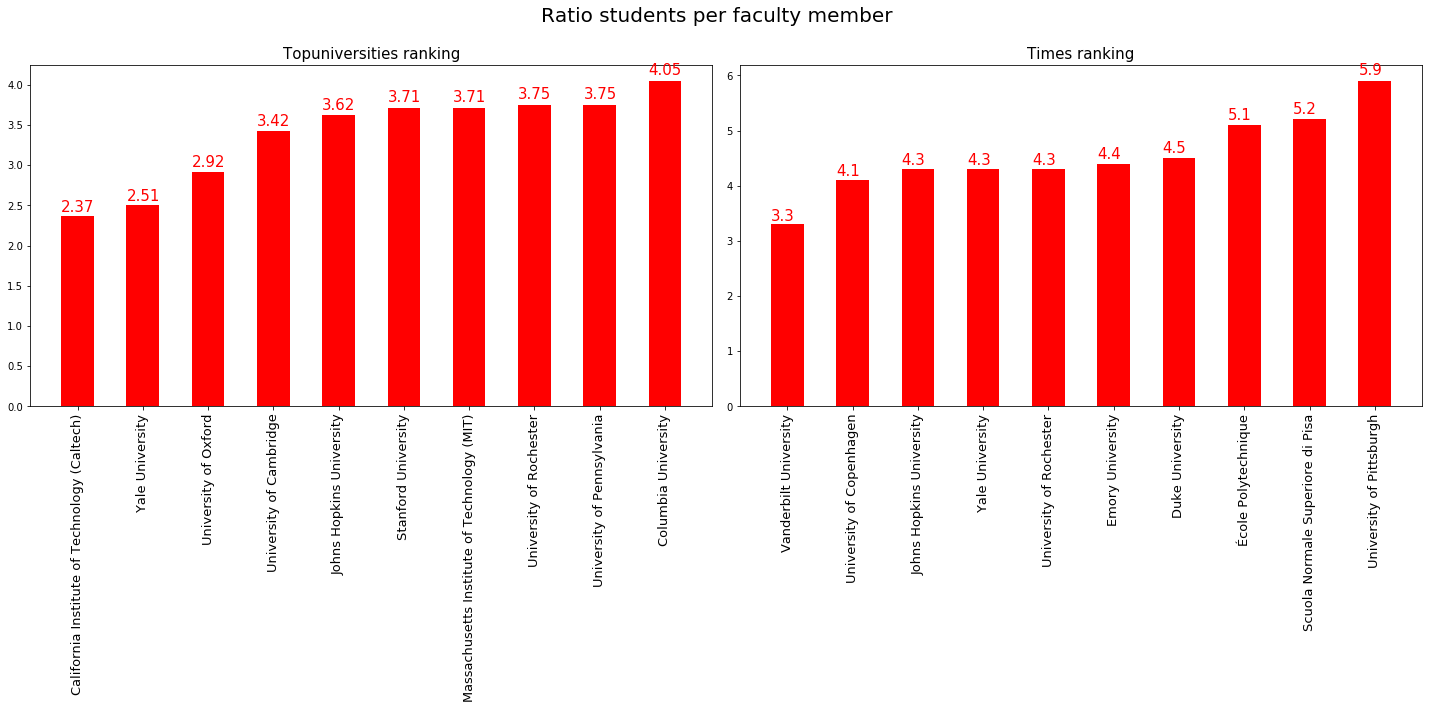

In [19]:
tmp_topuni = df_topuni.sort_values(by=['ratio_students_per_faculty_member']).head(10)
tmp_times = df_times.sort_values(by=['ratio_students_per_faculty_member']).head(10)

plot_histogram(tmp_topuni, tmp_times, 'name', 'ratio_students_per_faculty_member', 
               title='Ratio students per faculty member', xlab='University', figsize=(7,5))

#### Ranking in term of ratio of international students

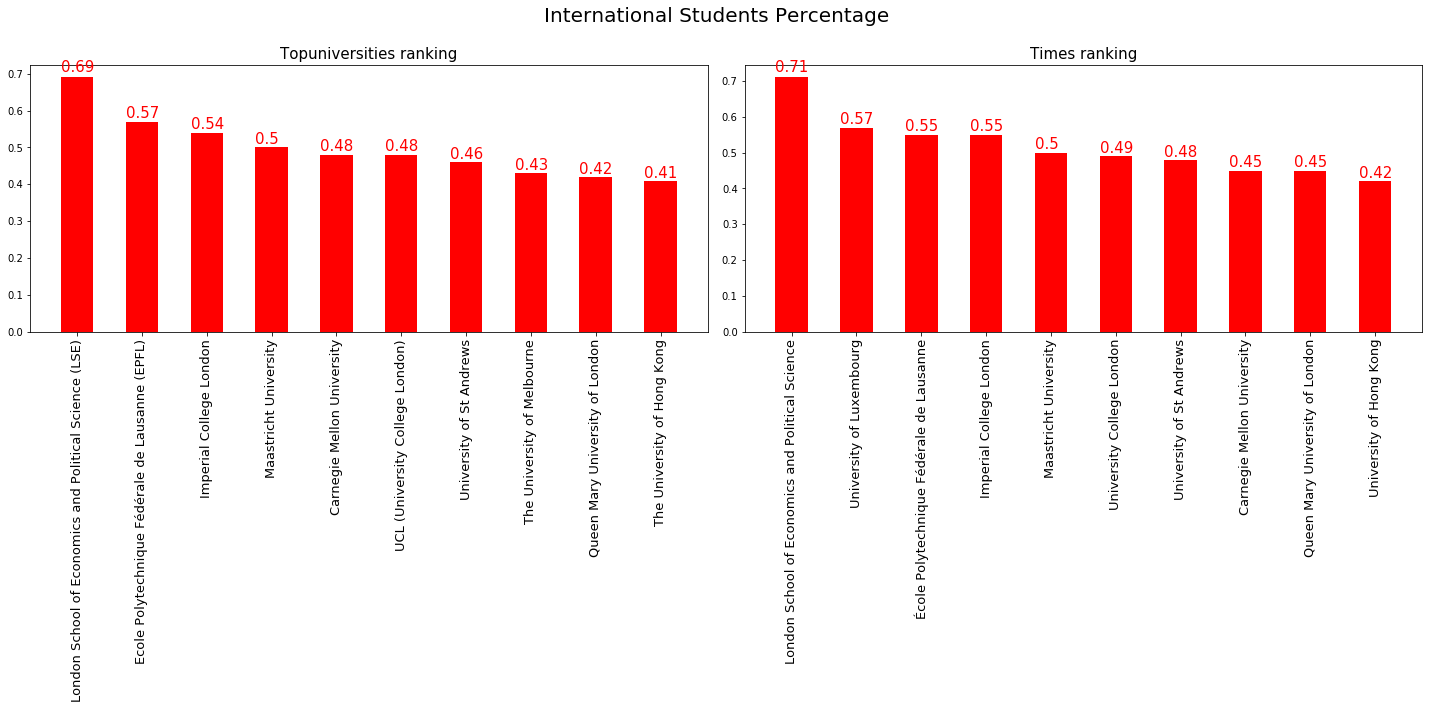

In [20]:
# ratio of international students
tmp_topuni = df_topuni.sort_values(by=['ratio_international_students'], ascending=False).head(10)
tmp_times = df_times.sort_values(ascending=False,by=['ratio_international_students']).head(10)

plot_histogram(tmp_topuni, tmp_times, 'name', 'ratio_international_students', 
               title='International Students Percentage', xlab='University', figsize=(7,5))

### Aggregated by country
Now, let's plot the same results aggregated by country.

#### Ranking of countries in term of ratio of students to staff in their universities

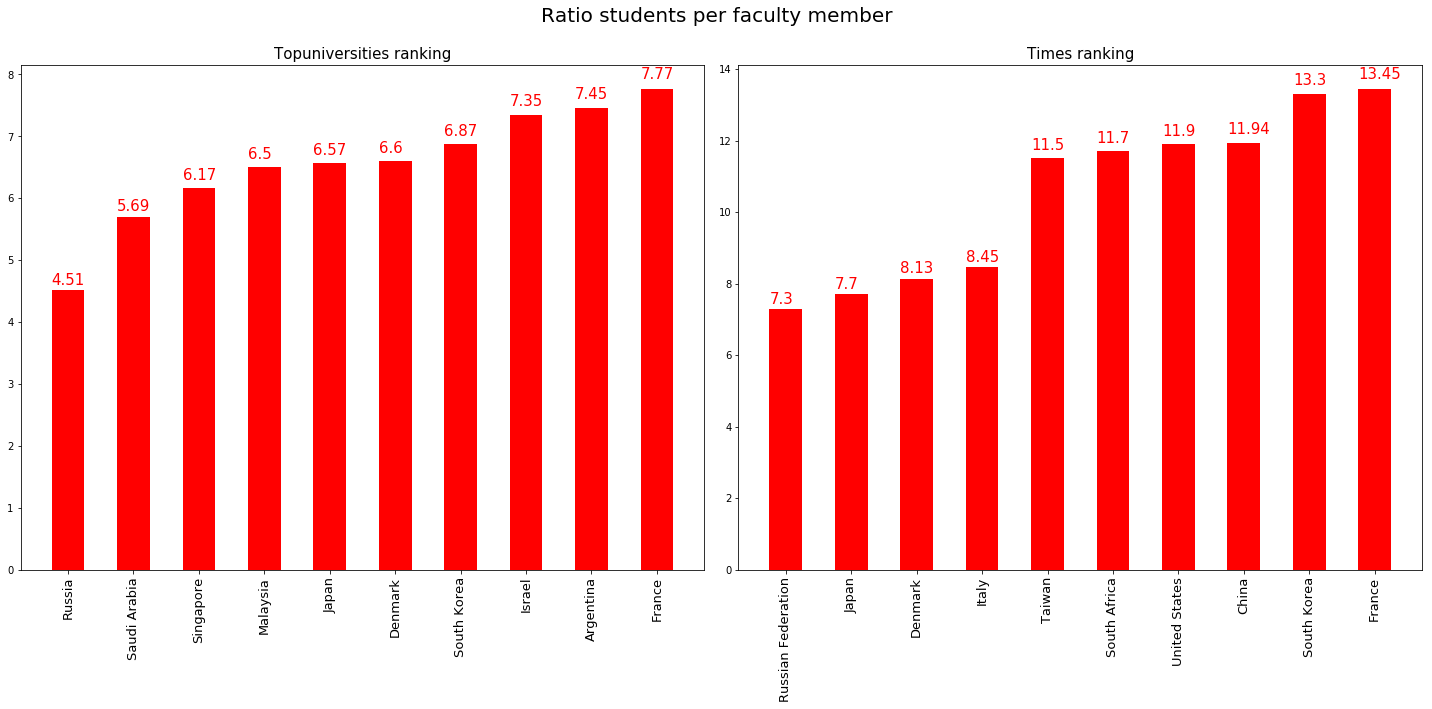

In [21]:
tmp_topuni = df_topuni.groupby('country').mean().sort_values(by=['ratio_students_per_faculty_member']).head(10)
tmp_times = df_times.groupby('country').mean().sort_values(by=['ratio_students_per_faculty_member']).head(10)

tmp_topuni.reset_index(inplace=True)
tmp_times.reset_index(inplace=True)

plot_histogram(tmp_topuni, tmp_times,'country', 'ratio_students_per_faculty_member', 
               title='Ratio students per faculty member', xlab='Country', figsize=(7,5))

#### Ranking of countries in term of international students percentage in their universities

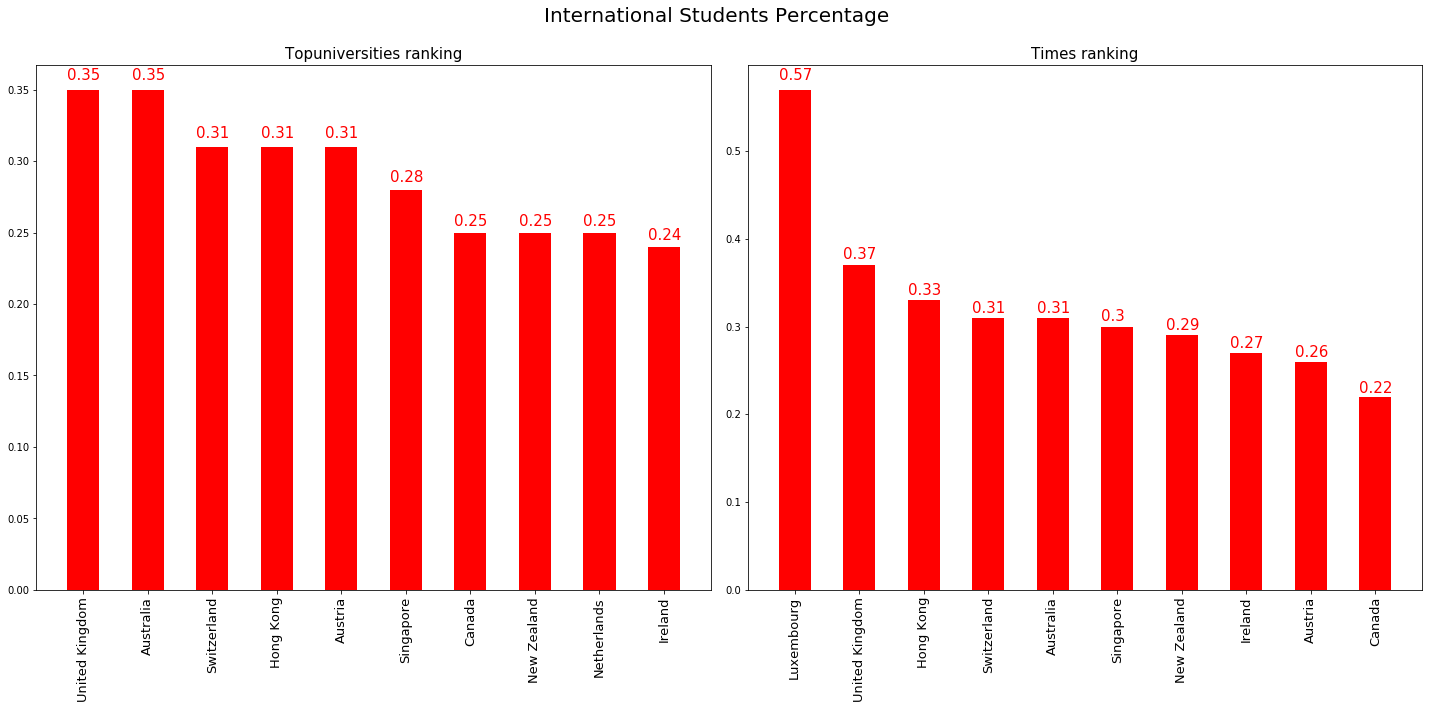

In [22]:
tmp_topuni = df_topuni.groupby('country').mean().sort_values(ascending=False,
                                                             by=['ratio_international_students']).head(10)
tmp_times = df_times.groupby('country').mean().sort_values(ascending=False,
                                                           by=['ratio_international_students']).head(10)

tmp_topuni.reset_index(inplace=True)
tmp_times.reset_index(inplace=True)

plot_histogram(tmp_topuni, tmp_times,'country', 'ratio_international_students', 
               title='International Students Percentage', xlab='Country', figsize=(7,5))

### Aggregated by region
Now, let's plot the same results aggregated by region.

#### Ranking of regions in term of ratio of international students in their universities

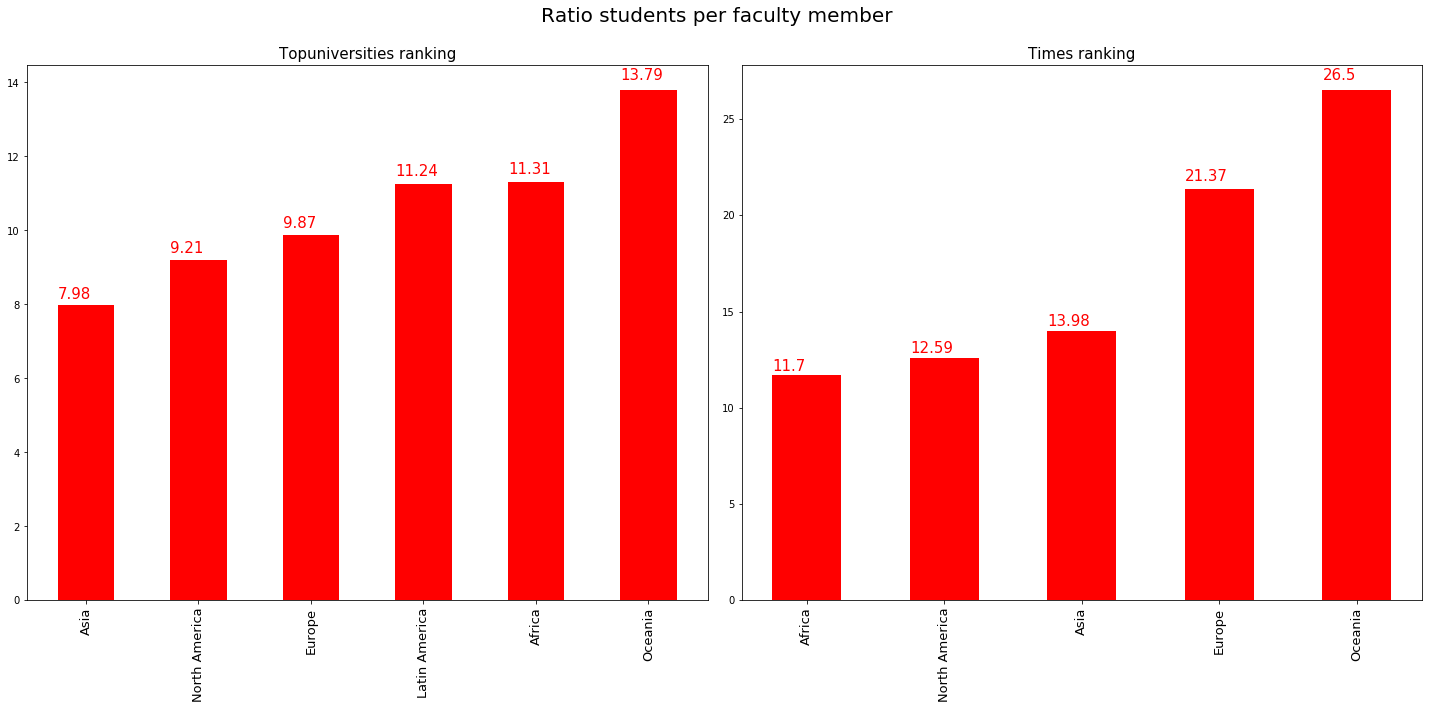

In [23]:
tmp_topuni = df_topuni.groupby('region').mean().sort_values(by=['ratio_students_per_faculty_member']).head(10)
tmp_topuni.reset_index(inplace=True)

tmp_times = df_times.groupby('region').mean().sort_values(by=['ratio_students_per_faculty_member']).head(10)
tmp_times.reset_index(inplace=True)

plot_histogram(tmp_topuni, tmp_times,'region', 'ratio_students_per_faculty_member', title='Ratio students per faculty member',
               xlab='region', figsize=(7,5))

#### Ranking of regions in term of ratio of students to staff in their universities

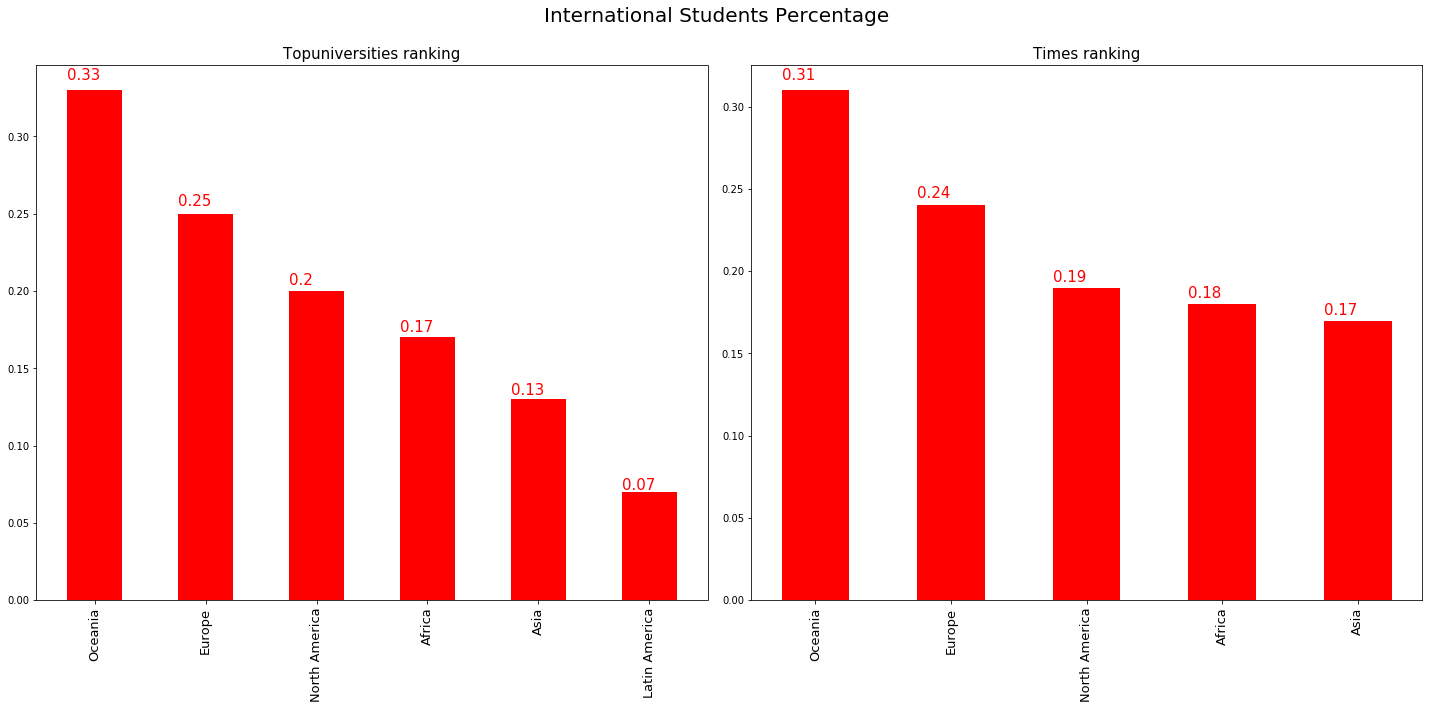

In [24]:
tmp_topuni = df_topuni.groupby('region').mean().sort_values(ascending=False,by=['ratio_international_students']).head(10)
tmp_topuni.reset_index(inplace=True)

tmp_times = df_times.groupby('region').mean().sort_values(ascending=False,by=['ratio_international_students']).head(10)
tmp_times.reset_index(inplace=True)

plot_histogram(tmp_topuni, tmp_times,'region', 'ratio_international_students', title='International Students Percentage',
               xlab='Region', figsize=(7,5))

# Merging the DataFrames

First, we get the total number of distinct University names in both datasets. These are not matched yet, so there may be duplicates.

In [25]:
names_topuni = set(df_topuni.loc[:, 'name'])
names_times = set(df_times.loc[:, 'name'])
names = names_times.union(names_topuni)
len(names)

295

#### Looking for universities that have different names in the two rankings but are the same

To do that we use a library calle fuzzywuzzy. It uses the Levenshtein distance that is meant to measure how two strings are close to each other to compute a matching score between two strings.
A score of 100 means the two strings are the same and for example:

$ score($'The University of Exeter', 'University of Exeter'$) = 95$

For each university name in the TopUniversities ranking, we look for the university that has the highest matching score in the Times ranking.

In [26]:
from fuzzywuzzy import fuzz, process
from pprint import pprint

In [27]:
n = {}
for name in names_topuni:
    test = process.extractOne(name, names_times)
    if test[0] != name and test[1] > 90:
        n[test[0]] = name
        print(name, test)

Ecole Polytechnique Fédérale de Lausanne (EPFL) ('École Polytechnique Fédérale de Lausanne', 91)
The Chinese University of Hong Kong (CUHK) ('Chinese University of Hong Kong', 95)
KAIST - Korea Advanced Institute of Science & Technology ('Korea Advanced Institute of Science and Technology (KAIST)', 95)
The University of Tokyo ('University of Tokyo', 95)
National Taiwan University (NTU) ('National Taiwan University', 95)
The Australian National University ('Australian National University', 95)
Pohang University of Science And Technology (POSTECH) ('Pohang University of Science and Technology', 95)
New York University (NYU) ('New York University', 95)
The Hong Kong University of Science and Technology ('Hong Kong University of Science and Technology', 96)
The Hong Kong Polytechnic University ('Hong Kong Polytechnic University', 95)
Ecole Polytechnique ('École Polytechnique', 97)
University of California, Los Angeles (UCLA) ('University of California, Los Angeles', 95)
The University of N

By looking at the list, we see the only mismatch is with the University of Bergen that we remove from the dictionnary.

In [28]:
del n['University of Bern']

We can find a couple of more matchings by setting the level of match at 80 rather than 90 but in this case there are a lot of mismatch. The matches are added by hand to the dictionnary.

In [29]:
n['University of Tübingen'] = 'Eberhard Karls Universität Tübingen'
n['Free University of Berlin'] = 'Freie Universitaet Berlin'
n['Humboldt University of Berlin'] = 'Humboldt-Universität zu Berlin'
n['Wageningen University & Research'] = 'Wageningen University'
n['University of Montreal'] = 'Université de Montréal'
n['Trinity College Dublin'] = 'Trinity College Dublin, The University of Dublin'
n['Heidelberg University'] = 'Ruprecht-Karls-Universität Heidelberg'
n['Scuola Superiore Sant’Anna'] = "Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento"
n['The University of New South Wales (UNSW Sydney)'] = 'University of New South Wales'
n['University of Freiburg'] = 'Albert-Ludwigs-Universitaet Freiburg'
n['Autonomous University of Barcelona'] =  'Universitat Autònoma de Barcelona'
n['Technical University of Berlin'] = 'Technische Universität Berlin (TU Berlin)'
n['Pierre and Marie Curie University'] = 'Université Pierre et Marie Curie (UPMC)'
n['University of New South Wales'] = 'The University of New South Wales (UNSW Sydney)'

We can now, for the matchings found, change the university names in the Times ranking to have the same as in the TopUniversities ranking.

In [30]:
for i in range(len(df_times)):
    tmp = df_times.loc[i, 'name']
    if tmp in n.keys():
        df_times.loc[i, 'name'] = n[tmp]
        
names_topuni = set(df_topuni.loc[:, 'name'])
names_times = set(df_times.loc[:, 'name'])
names = names_times.union(names_topuni)
len(names)

241

In [31]:
inter = names_times.intersection(names_topuni)
len(inter)

159

In [32]:
df_topuni.head()

,name,rank,region,country,international_faculty_members,international_students,total_faculty_members,total_students,ratio_students_per_faculty_member,ratio_international_students
0,Massachusetts Institute of Technology (MIT),1,North America,United States,1679,3717,2982,11067,3.711268,0.335863
1,Stanford University,2,North America,United States,2042,3611,4285,15878,3.705484,0.227422
2,Harvard University,3,North America,United States,1311,5266,4350,22429,5.156092,0.234785
3,California Institute of Technology (Caltech),4,North America,United States,350,647,953,2255,2.366212,0.286918
4,University of Cambridge,5,Europe,United Kingdom,2278,6699,5490,18770,3.418944,0.356899


In [33]:
df_times.head()

,name,rank,country,total_students,ratio_students_per_faculty_member,ratio_international_students,total_faculty_members,international_students,region
0,University of Oxford,1,United Kingdom,20409,11.2,0.38,1822,7755,Europe
1,University of Cambridge,2,United Kingdom,18389,10.9,0.35,1687,6436,Europe
2,California Institute of Technology (Caltech),3,United States,2209,6.5,0.27,340,596,North America
3,Stanford University,3,United States,15845,7.5,0.22,2113,3486,North America
4,Massachusetts Institute of Technology (MIT),5,United States,11177,8.7,0.34,1285,3800,North America


In [34]:
df_times.columns = ['name', 'times_rank', 'country', 'times_total_students','times_ratio_students_per_faculty_member',
                    'times_ratio_international_students', 'times_total_faculty_member',
                    'times_international_students', 'region']

In [35]:
df_topuni.columns = ['name', 'topuni_rank', 'region', 'country', 'topuni_international_faculty_members',
       'topuni_international_students', 'topuni_total_faculty_members', 'topuni_total_students',
       'topuni_ratio_students_per_faculty_member', 'topuni_ratio_international_students']

## Universities appearing in both rankings: Correlations
In the further analysis below, we chose to keep only Universities contained in both rankings.

In [50]:
df = df_times.merge(df_topuni, on='name', how='inner')

In [51]:
for i in range(len(df)):
    if df.loc[i, 'country_y'] != df.loc[i, 'country_x']:
        print(i, df.loc[i, 'country_y'], df.loc[i, 'country_x'])

157 Russia Russian Federation


The only mismatch is between Russia and the Russian Federation and that is not a real mismatch. We can then drop a column of countries.
There cannot be any mismatch between regions as we extracted the regions from the top_uni dataset.

In [52]:
df.columns

Index(['name', 'times_rank', 'country_x', 'times_total_students',
       'times_ratio_students_per_faculty_member',
       'times_ratio_international_students', 'times_total_faculty_member',
       'times_international_students', 'region_x', 'topuni_rank', 'region_y',
       'country_y', 'topuni_international_faculty_members',
       'topuni_international_students', 'topuni_total_faculty_members',
       'topuni_total_students', 'topuni_ratio_students_per_faculty_member',
       'topuni_ratio_international_students'],
      dtype='object')

In [53]:
df = df[['name', 'times_rank', 'topuni_rank', 'country_x', 'region_x', 'times_total_students', 'topuni_total_students',
         'times_ratio_students_per_faculty_member', 'topuni_ratio_students_per_faculty_member',
         'times_ratio_international_students', 'topuni_ratio_international_students',
         'times_total_faculty_member', 'topuni_total_faculty_members', 
         'times_international_students', 'topuni_international_students','topuni_international_faculty_members']]
df.columns = ['name', 'times_rank', 'topuni_rank', 'country', 'region', 'times_total_students', 
              'topuni_total_students',
              'times_ratio_students_per_faculty_member', 'topuni_ratio_students_per_faculty_member',
              'times_ratio_international_students', 'topuni_ratio_international_students',
              'times_total_faculty_member', 'topuni_total_faculty_members', 
              'times_international_students', 'topuni_international_students','topuni_international_faculty_members']

In [54]:
df.head()

,name,times_rank,topuni_rank,country,region,times_total_students,topuni_total_students,times_ratio_students_per_faculty_member,topuni_ratio_students_per_faculty_member,times_ratio_international_students,topuni_ratio_international_students,times_total_faculty_member,topuni_total_faculty_members,times_international_students,topuni_international_students,topuni_international_faculty_members
0,University of Oxford,1,6,United Kingdom,Europe,20409,19720,11.2,2.921481,0.38,0.372870,1822,6750,7755,7353,2964
1,University of Cambridge,2,5,United Kingdom,Europe,18389,18770,10.9,3.418944,0.35,0.356899,1687,5490,6436,6699,2278
2,California Institute of Technology (Caltech),3,4,United States,North America,2209,2255,6.5,2.366212,0.27,0.286918,340,953,596,647,350
3,Stanford University,3,2,United States,North America,15845,15878,7.5,3.705484,0.22,0.227422,2113,4285,3486,3611,2042
4,Massachusetts Institute of Technology (MIT),5,1,United States,North America,11177,11067,8.7,3.711268,0.34,0.335863,1285,2982,3800,3717,1679


## Universities appearing only in one ranking
For record, we also display the Universities which appear only in one of both rankings.

In [55]:
df_topuni_r=pd.DataFrame(df_topuni[(~df_topuni["name"].isin(df["name"]))])
df_times_r=pd.DataFrame(df_times[(~df_times["name"].isin(df["name"]))])

In [56]:
display(df_topuni_r.head(2))
display(df_times_r.head(2))
print(str(len(df)) + " common rankings in total")
print(str(len(df_times_r))+ " Universities of the time ranking not contained in the Topuni ranking")
print(str(len(df_topuni_r))+ " Universities of the topuni ranking not contained in the Times ranking")

,name,topuni_rank,region,country,topuni_international_faculty_members,topuni_international_students,topuni_total_faculty_members,topuni_total_students,topuni_ratio_students_per_faculty_member,topuni_ratio_international_students
42,"Ecole normale supérieure, Paris",43,Europe,France,75,374,178,1907,10.713483,0.19612
55,Tokyo Institute of Technology,56,Asia,Japan,191,1071,1563,9832,6.290467,0.10893


,name,times_rank,country,times_total_students,times_ratio_students_per_faculty_member,times_ratio_international_students,times_total_faculty_member,times_international_students,region
34,LMU Munich,34,Germany,36091,15.6,0.15,2314,5414,Europe
38,Karolinska Institute,38,Sweden,7424,10.9,0.19,681,1411,Europe


159 common rankings in total
41 Universities of the time ranking not contained in the Topuni ranking
41 Universities of the topuni ranking not contained in the Times ranking


### Correlation
The result below allows to visualize correlations between each variable. First, we visualize variable correlations for each website individually
#### Topuniversities

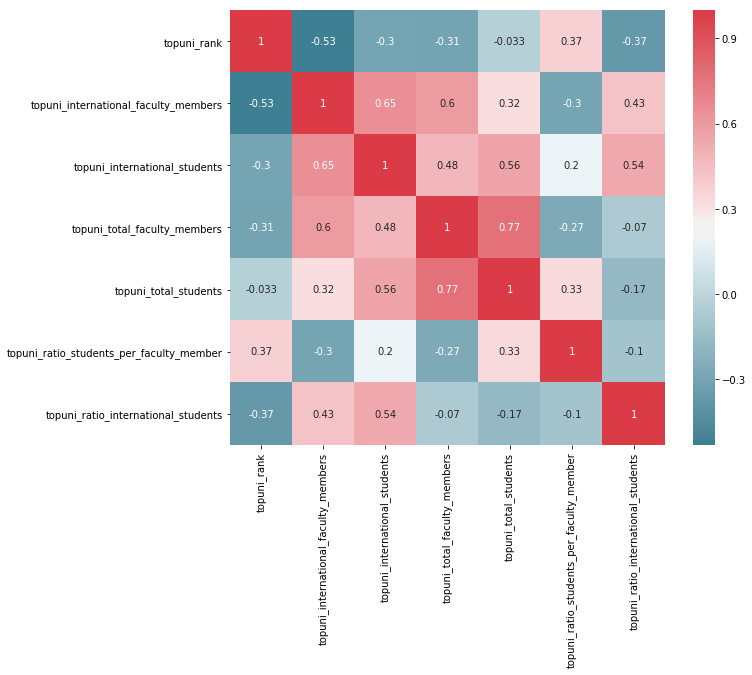

In [69]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df_topuni.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)
plt.show()

### Interpretation:
#### Rank
- The rank of the University correlates most positively (`0.37`) with the ratio students to factulty members. In fact, the correlation direction here has to be read differently, because a higher rating means a "lower number", therefore this correlation is negative. The more students with respect to faculty member the University has, the less people there are.
- The rank of the University correlates has the strongest negative correlation (`-0.53`) with international faculty members and international students, respectively (`-0.37`). Again, this correlation is actually positive because high rank means low rank number.

#### Other variables
- There is a strong positive correlation between international faculty members and international students (`0.65`).
- Similarly the number of faculty members strongly correlates with the number of students (`0.77`), representing simply big or small universities.

#### Times Higher Education

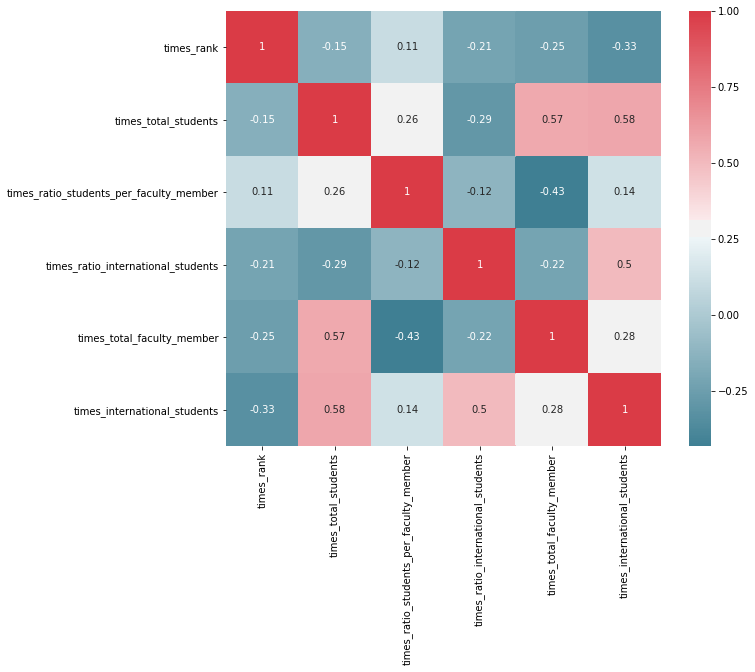

In [73]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df_times.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)
plt.show()

Similar tendencies as above can be seen. To visualize the differences more closely, let's show the correlogram of the merged dataset.

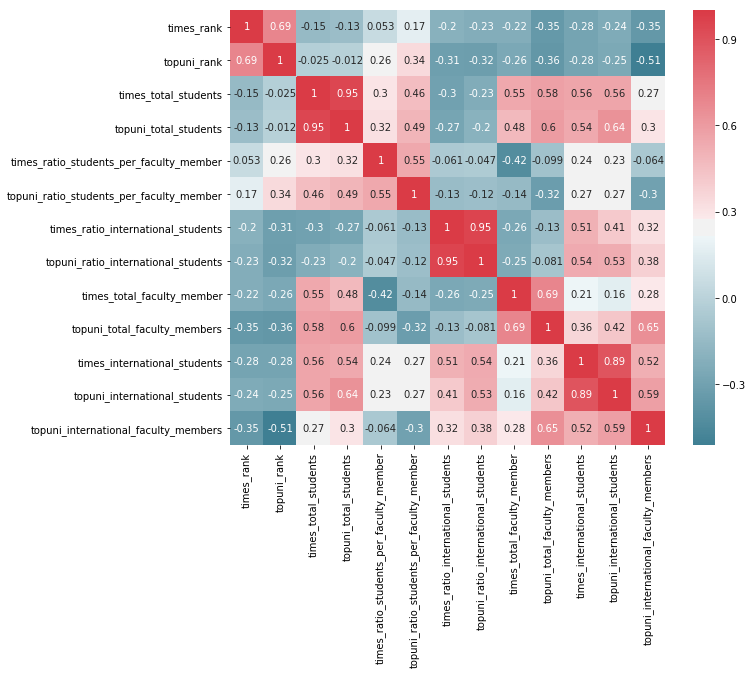

In [74]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)
plt.show()

### Interpretation
#### Rank (first and second column, or row, respectively)
The correlation of the ranking with international faculty members and students is strong with both datsets, although it is stronger (`-0.51`) for ther topuni dataset, for which the international faculty member information was sourced. Interestingly, this shows that taking into account the criterion of international faculty members influences the topuniversities ranking.
#### Other comments
The correlation between the variables of both ranking websites is generally quite strong, as the red 2\*2-rectangles along the diagonal of the matrix suggest. The correlation is least strong for the `ratio_students_by_faculty_member` and `total_faculty_members` which might have been calculated using different methods.

## Best University taking into account both approaches (TO DO)
Following aggregation schemes can be taken into account
- Mean between rankings: this seems most straight-forward, as it considers both rankings of equal trustworthiness and assumes they can be weighted without any preprocessing.
- Weighted mean taking into account other variables such as international students percentage. Since this was 
- Weigthed mean over all categories, excluding the ranking
- Trying to decorrelate variables that are only present in one dataset?

### Mean between rankings

In [80]:
df["rank_mean"]=(df["times_rank"]+df["topuni_rank"])/2


Using this method, the top 10 universities are:

In [89]:
df[["name","rank_mean"]].sort_values(by="rank_mean").head(10)

,name,rank_mean
3,Stanford University,2.5
4,Massachusetts Institute of Technology (MIT),3.0
0,University of Oxford,3.5
1,University of Cambridge,3.5
2,California Institute of Technology (Caltech),3.5
5,Harvard University,4.5
7,Imperial College London,8.0
8,University of Chicago,9.0
6,Princeton University,10.0
9,ETH Zurich - Swiss Federal Institute of Techno...,10.0


Best university in terms of international students

In [93]:
df["mean_ratio_international_students"]=(df["times_ratio_international_students"]+df["topuni_ratio_international_students"])/2
df[["name","mean_ratio_international_students"]].sort_values(by="rank_mean").head(10)

KeyError: 'rank_mean'